# Laminar quasi-1d solutions using Gradient Descent

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lib import pseudo 
from scipy.optimize import minimize

%matplotlib inline

_dealiasFun = lambda arr, y, yDealias : pseudo.chebint( pseudo.chebint(arr, yDealias), y)

# Stage 1: Barebones solver

### Solve for Poiseuille and PCoF

------------------------
Solver is defined by
1. Initial state
2. Cost definition
3. Jacobian definition
4. Tuning parameters: relaxRate, weightWindow

relaxRate is the relaxation factor for making corrections. 

weightWindow is used to allow corrections to remember earlier corrections, i.e. using momentum to stabilize gradient descent

--------------------

We'll consider the simplest case, 
$$ -P_x  + \frac{1}{Re} \partial_{yy}(U+u) = 0   $$
For Poiseuille flow, $P_x = -2/Re$ with $U= 1-y^2$, \\
For PCoF, $P_x = 0$ with $U= y$. 

For just the fluctuations, we have
$$ \partial_{yy} u = 0 $$
with the velocity $0$ at both walls. 

** The cost function is **
$$ F(u) = || u_{yy} ||_2 $$

This raises the question, how do I impose BCs? I should NOT use internal points only, because pressure becomes very hard to deal with. I can't just ignore pressure at the walls, or set it to zero. I must retain nodes at the wall. 

While retaining wall nodes, I can implement BCs in two ways: 
1. Add the squares (or absolute values) of velocities at the wall to the cost function. 
2. Implicitly impose BCs. For instance, define $u = (1-y^2) \tilde{u}$ and solve for $\tilde{u}$. 

I will try both approaches below, using a kwarg, BC=False, to switch between the two. 

With BCs imposed by adding squares at the end, (weighted extra to make them important),
$$ F(\mathbf{u}) = || D^2 \mathbf{u} ||^2 + K \mathbf{u}^2(y=1) + K\mathbf{u}^2(y=-1). $$
$D^2$ is the differentiation matrix for the Chebyshev collocation method that we'll be using, and $\mathbf{u}$ is a column vector. 

Supposing that the norm above is defined as
$$ || \mathbf{b} ||^2 = \sum \omega_j b_j^2, $$
for some vector $\mathbf{\omega}$ of weights. This is important for the collocation method we're using. 

The Jacobian for this cost is given by
$$ J(\mathbf{u})_i = 2 K (\mathbf{u}_0 \delta_{i,0} + \mathbf{u}_{N-1}\delta_{i,N-1} ) + 2 \sum\limits_{0}^{N-1} w_j (D^2 \mathbf{u})_j  D^2\lbrack j,i\rbrack $$
See derivation at the end. 


**Need to test for this Jacobian; i.e., the u-derivative of u_yy**

### Implicit Boundary conditions

__Call the velocity $\tilde{u}$, and express it as__
$$ \tilde{u} = (1-y^2) u$$
so that the velocity, $\tilde{u}$, satisfies the boundary conditions for any profile for $u$. 

The cost function does not need the terms due to the BCs anymore. 
$$ F(u) = \sum\limits_{j=0}^{N-1} w_j ( \tilde{u}'')^2_j 
= \sum\limits_{j=0}^{N-1} w_j \big(  -2u -4yu' + (1-y^2)u''\big)^2_j $$

Scipy has gradient descent functions that don't necessarily need a Jacobian. I could just use the cost function to get them to work for me. 

#### Jacobian: book-keeping
For later use, I'll still define the Jacobian. Before the Jacobian itself, we'll look at partial derivatives of a few different terms to make it easier in defining the Jacobian. Remember that $y$ is an independent variable, so $\frac{dy}{du}$ will be zero. The partial derivatives, $\frac{\partial u'}{\partial u}$ and $\frac{\partial u''}{\partial u}$ are calculated as follows. First, we say that the derivatives $u'$ and $u''$ are, under our collocation method, just $D\mathbf{u}$ and $D^2 \mathbf{u}$. Here, the velocities are boldened to emphasize they are (column) vectors. $D$ and $D^2$ are __constant__ differentiation matrices. For any product $A\mathbf{u}$, its derivative with respect to $\mathbf{u}$ is composed from the partial derivative $\partial (Au)_j/\partial u_i$:

$$ \frac{\partial (Au)_j}{\partial u_i} = \frac{\partial A\lbrack j,:\rbrack \mathbf{u} }{\partial u_i }
= \lim_{\epsilon \to 0 } \frac{  A\lbrack j,:\rbrack (\mathbf{u} + \epsilon \mathbf{e}_i ) -A\lbrack j,:\rbrack (\mathbf{u} + \epsilon \mathbf{e}_i ) }{ 2\epsilon }
= \lim_{\epsilon \to 0 } \frac{ 2 \epsilon A\lbrack j,i\rbrack }{ 2\epsilon } = A \lbrack j,i\rbrack $$
where $\mathbf{e}_i$ is the unit vector with zeros everywhere except at the $i^{th}$ index. 

#### Jacobian: expression
Now we're ready to define the Jacobian. 
$$ J(\mathbf{u}) = \frac{\partial F}{\partial \mathbf{u}} 
= \frac{ \partial \big\{ \sum\limits_j w_j \big(  -2u -4yu' + (1-y^2)u''\big)^2_j \big\} }{\partial \mathbf{u} }$$
$$ J(\mathbf{u})_i = \frac{ \partial \big\{ \sum\limits_j w_j \big(  -2u -4yu' + (1-y^2)u''\big)^2_j \big\} }{\partial u_i }
= \sum\limits_j 2 w_j \big(  -2u -4yu' + (1-y^2)u''\big)_j \big\{ -2\delta_{j,i} -4y \frac{\partial (Du)_j}{\partial u_i}
+ (1-y^2) \frac{\partial (D^2 u)_j}{\partial u_i} \big\}$$
From the previous derivation for partial derivatives of $Au$, 
$$ J(\mathbf{u})_i = \sum\limits_j 2 w_j \big(  -2u -4yu' + (1-y^2)u''\big)_j \big\{
-2I\lbrack j,i \rbrack -4y D\lbrack j,i\rbrack + (1-y^2) D^2\lbrack j, i \rbrack \big\}$$

$I$ is the identity matrix and represents the Kroenecker delta $\delta_{j,i}$. 



## Implicit BCs, version 2
See next section for comments 

$$ F(\tilde{u}) =\text{dot}( q, u''^2) $$

$$ \frac{F}{\tilde{\mathbf{u}}} =  \text{qdot}(2 u'', A2) $$

In [663]:
def initSystem_test0(N, scale=1.e-3, v2=False):
    """
    Define initial state, cost function, and Jacobian
    
    Arguments:
        N: Number of collocation nodes (including wall nodes)
        Keywords:
        BC (=True): If True, add abs values of u(walls) to cost
                        else, define u = (1-y^2) u_til, and solve for u_til
        scale (=1.e-3): Amplitude of initial state
        v2 (=False): If True, use new formulation (see next section)
          
    Outputs:
        state: np.ndarray(shape=(N,)), random values, scaled by argument 'scale'
        costFun: Function, produces costFun(state) = scalar
        jacFun: Function, produces jacFun(state) = np.ndarray(shape=(N,))
        
    """
        
    y, DM = pseudo.chebdif(N,2)
    D2 = DM[:,:,1]
    q = (pseudo.clencurt(N)).flatten()
    #weightArr = np.ones(N)/N
    
    randArr =  np.random.randn(N)# ; randArr[N//2:] = 0.
    state0 = np.real((1.-y**2) * pseudo.chebcoll_vec( randArr ) )
    # Random coefficients for Chebyshev polynomials, then converted to collocation values
    
    yColumn = y.reshape((N,1))
    qdot = lambda tmpArr, tmpMat: (q*tmpArr).reshape(1,N) @ tmpMat
    
    def costFun_BC(arr):
        # F(u) = \sum_j w_j (  -2u -4yu' + (1-y^2)u'')^2_j
        arr_y = D1@arr
        arr_yy = D2@arr
        unWeighted = (-2.* arr - 4.*y*arr_y + (1.-y**2)* arr_yy)**2
        
        return q @ unWeighted
        
    def costFun_BC_v2(arr):
        ut = arr.flatten(); uty = D1@ut; utyy = D2@ut
        u = (1.-y**2) * ut
        uy = -2.*y*ut + (1.-y**2)*uty
        #uyy = (-2.* ut - 4.*y*uty + (1.-y**2)* utyy)
        uyy = D2 @ u
        
        return q @ (( uyy )**2)
    
    def gradFun_BC(arr):
        #J_i = \sum_j { 2 w_j ( -2u -4yu' + (1-y^2)u'')_j } {-2 I_{j,i} - 4y_j D[j,i] + (1-y_j^2) D^2[j,i]}
        arr = arr.flatten()
        arr_y = D1@ arr
        arr_yy = D2 @ arr
        #Terms in first brace
        term1 = (2.* q*(-2.*arr - 4.*y*arr_y + (1.-y**2)*arr_yy) ).reshape((1,arr.size))
        term2 = -2.*np.identity(N) -4.* yColumn * D1 + (1.-yColumn**2) * D2
        
        return (term1 @ term2).flatten()
    
    def gradFun_BC_v2(arr):
        u = (1.-y**2) * arr.flatten()
        uy = D1 @ u
        uyy = D2 @ u
        A2 = -2.* np.identity(N) - 4.* yColumn * D1 + (1.-yColumn**2) * D2
        
        return qdot(2.*uyy, A2).flatten()
        
    
    state0 = scale * state0/np.linalg.norm(state0)
    
    if v2 :
        return state0, costFun_BC_v2, gradFun_BC_v2
    else :
        return state0, costFun_BC, gradFun_BC

    
    

### Test aliasing effects (wall-normal) when going from $\tilde{u}$ to $u$

In [664]:
# Smooth functions 

print("Testing with poly of power 6")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]

costFun1 = initSystem_test0(N,v2=False)[1]
costFun2 = initSystem_test0(N,v2=True)[1]
normdef = lambda arr: 2.*pseudo.chebnorm(arr,N)**2

testArr_til = (0.1)*(y - y**2 + y**4)
testArr = (1.-y**2)* testArr_til
# ut = 0.1*(y-y^2+y^4); uty = 0.1*(1-2y+4y^3); utyy = 0.1*(-2+12y^2)
# u = 0.1*(y-y^2-y^3+2y^4  -y^6)
# uy = 0.1*(1-2y-3y^2+8y^3-6y^5)
# uyy= 0.1*(-2-6y+24y^2-30y^4)
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("uty(y=1), uty(y=0).  Analytical:0.3, 0.1. tilde: %.10f, %.10f" %( uty[0], uty[N//2] ) )
print("uy(y=1), uy(y=0). Analytical: -0.2, 0.1. tilde: %.10f, %.10f. Full: %.10f, %.10f"%(uy1[0], uy1[N//2], uy2[0], uy2[N//2]) )
print("Rel. error in uy(tilde) and uy(full): %.10f" %(normdef(uy1-uy2)/(1.e-12+normdef(uy2))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("utyy(y=1), utyy(y=0).  Analytical:1.0, -0.2. tilde: %.10f, %.10f" %( utyy[0], utyy[N//2] ) )
print("uy(y=1), uy(y=0). Analytical: -1.4, -0.2. tilde: %.10f, %.10f. Full: %.10f, %.10f"%(uyy1[0], uyy1[N//2], uyy2[0], uyy2[N//2]) )
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()



# 'Volatile' functions 

print("Testing with poly of power 25")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]

testArr_til = (0.1)*(- y**2 + y**18 - y**25)
testArr = (1.-y**2)* testArr_til
# ut = 0.1*(-1y2 + 1y18 - 1y25); uty = 0.1*( -2y1 + 18y17 - 25y24); utyy = 0.1*(-2 + 306y^16 - 600y^23)
# u = 0.1*(-1y2 + 1y4 + 1y18 - 1y20 - 1y25 + 1y27)
# uy = 0.1*(-2y + 4y3 + 18y17 - 20y19 - 25y24 + 27y26)
# uyy= 0.1*(-2 + 12y2 + 306y16 - 380y18 - 600y23 + 702y25)
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("uty(y=1), uty(y=0).  Analytical: -0.9, 0.0. tilde: %.10f, %.10f" %( uty[0], uty[N//2] ) )
print("uy(y=1), uy(y=0). Analytical: 0.2, 0.0. tilde: %.10f, %.10f. Full: %.10f, %.10f"%(uy1[0], uy1[N//2], uy2[0], uy2[N//2]) )
print("Rel. error in uy(tilde) and uy(full): %.10f" %(pseudo.chebnorm(uy1-uy2,N)/(1.e-12+pseudo.chebnorm(uy2,N))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("utyy(y=1), utyy(y=0).  Analytical: -29.6, -0.2. tilde: %.10f, %.10f" %( utyy[0], utyy[N//2] ) )
print("uy(y=1), uy(y=0). Analytical: 3.8, -0.2. tilde: %.10f, %.10f. Full: %.10f, %.10f"%(uyy1[0], uyy1[N//2], uyy2[0], uyy2[N//2]) )
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()


# Spiky functions 

print("Testing with poly of power 34")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]

testArr_til = (0.1)*(- y**2 + y**19 - y**34)
testArr = (1.-y**2)* testArr_til
# ut = 0.1*(-1y2 + 1y19 - 1y34); uty = 0.1*( -2y1 + 19y18 - 34y33); utyy = 0.1*(-2 + 342y17 - 1122y32)
# u = 0.1*(-1y2 + 1y4 + 1y19 - 1y21 - 1y34 + 1y36)
# uy = 0.1*(-2y1 + 4y3 + 19y18 - 21y20 - 34y33 + 36y35)
# uyy= 0.1*(-2 + 12y2 + 342y17 - 420y19 - 1122y32 + 1260y34);
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("uty(y=1), uty(y=0).  Analytical: -1.7, 0.0. tilde: %.10f, %.10f" %( uty[0], uty[N//2] ) )
print("uy(y=1), uy(y=0). Analytical: 0.2, 0.0. tilde: %.10f, %.10f. Full: %.10f, %.10f"%(uy1[0], uy1[N//2], uy2[0], uy2[N//2]) )
print("Rel. error in uy(tilde) and uy(full): %.10f" %(pseudo.chebnorm(uy1-uy2,N)/(1.e-12+pseudo.chebnorm(uy2,N))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("utyy(y=1), utyy(y=0).  Analytical: -78.2, -0.2. tilde: %.10f, %.10f" %( utyy[0], utyy[N//2] ) )
print("uy(y=1), uy(y=0). Analytical: 7.0, -0.2. tilde: %.10f, %.10f. Full: %.10f, %.10f"%(uyy1[0], uyy1[N//2], uyy2[0], uyy2[N//2]) )
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()

np.random.seed(1)

print("Testing with random vector")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]

testArr_til = (0.1)*np.random.randn(N)
testArr = (1.-y**2)* testArr_til
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("Rel. error in uy(tilde) and uy(full): %.10f" %(pseudo.chebnorm(uy1-uy2,N)/(1.e-12+pseudo.chebnorm(uy2,N))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()


print("Testing with random Cheb coefficients")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]

testArr_til = (0.1)*pseudo.chebcoll_vec(np.random.randn(N))
testArr = (1.-y**2)* testArr_til
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("Rel. error in uy(tilde) and uy(full): %.10f" %(pseudo.chebnorm(uy1-uy2,N)/(1.e-12+pseudo.chebnorm(uy2,N))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()

print("Testing with random vector, after dealiasing to N-3")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]
ym3 = pseudo.chebdif(N-3,1)[0]

testArr_til = (0.1)*np.random.randn(N)
testArr_til = pseudo.chebint(pseudo.chebint(testArr_til, ym3), y)
testArr = (1.-y**2)* testArr_til
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("Rel. error in uy(tilde) and uy(full): %.10f" %(pseudo.chebnorm(uy1-uy2,N)/(1.e-12+pseudo.chebnorm(uy2,N))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()



print("Testing with random Cheb coefficients, after dealiasing to N-3")
print("=================================================")
N = 35
y, DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]
ym3 = pseudo.chebdif(N-3,1)[0]

testArr_til = (0.1)*pseudo.chebcoll_vec(np.random.randn(N))
testArr_til = pseudo.chebint(pseudo.chebint(testArr_til, ym3), y)
testArr = (1.-y**2)* testArr_til
ut = testArr_til; u = testArr

uty = D1@ut
uy1 =  -2.*y*ut  + (1.-y**2)*uty
uy2 = D1@u
print("First derivatives to 10 places")
print("Rel. error in uy(tilde) and uy(full): %.10f" %(pseudo.chebnorm(uy1-uy2,N)/(1.e-12+pseudo.chebnorm(uy2,N))  ) )


utyy = D2@ut
uyy1 = -2.*ut - 4.*y*uty + (1.-y**2)*utyy
uyy2 = D2@u
print()
print("Second derivatives to 10 places")
print("Rel. error in uyy(tilde) and uyy(full): %.10f" %(normdef(uyy1-uyy2)/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and uyy(tilde): %.10f" %( (normdef(uyy1)-costFun1(ut))/(1.e-12+normdef(uyy1))  ) )
print("Rel. error in costFun2 and uyy(full): %.10f" %( (normdef(uyy2)-costFun2(ut))/(1.e-12+normdef(uyy2))  ) )
print("Rel. error in costFun1 and costFun2: %.10f" %( (costFun1(ut)-costFun2(ut))/(1.e-12+normdef(ut))  ) )
print(); print()




Testing with poly of power 6
First derivatives to 10 places
uty(y=1), uty(y=0).  Analytical:0.3, 0.1. tilde: 0.3000000000, 0.1000000000
uy(y=1), uy(y=0). Analytical: -0.2, 0.1. tilde: -0.2000000000, 0.1000000000. Full: -0.2000000000, 0.1000000000
Rel. error in uy(tilde) and uy(full): 0.0000000000

Second derivatives to 10 places
utyy(y=1), utyy(y=0).  Analytical:1.0, -0.2. tilde: 1.0000000000, -0.2000000000
uy(y=1), uy(y=0). Analytical: -1.4, -0.2. tilde: -1.4000000000, -0.2000000000. Full: -1.4000000000, -0.2000000000
Rel. error in uyy(tilde) and uyy(full): 0.0000000000
Rel. error in costFun1 and uyy(tilde): 0.0000000000
Rel. error in costFun2 and uyy(full): 0.0000000000
Rel. error in costFun1 and costFun2: -0.0000000000


Testing with poly of power 25
First derivatives to 10 places
uty(y=1), uty(y=0).  Analytical: -0.9, 0.0. tilde: -0.9000000000, -0.0000000000
uy(y=1), uy(y=0). Analytical: 0.2, 0.0. tilde: 0.2000000000, -0.0000000000. Full: 0.2000000000, 0.0000000000
Rel. error in uy

C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:181: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:245: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:246: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:247: ComplexWarning: Casting complex values to real discards the imaginary part


1. __The second derivative is sensitive to premultiplication by $(1-y^2)$, because the derivative is very sensitive to change in values at the boundary in general__
2. __This sensitivity is very pronounced when the field/vector being differentiated has energy in the highest wavenumbers, especially for randomly initiated vectors.__
3. __Dealiasing can help. My strategy is to simply project the collocated vector to Cheb nodes with $N-3$ points, and then back to the original. To be precise, $N-2$ is enough for the projection, but adding the extra point is no big deal__

## Test gradFun

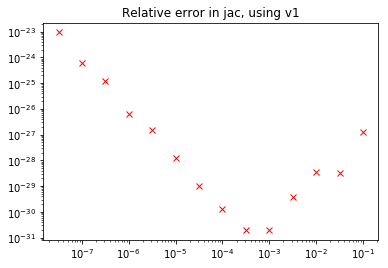

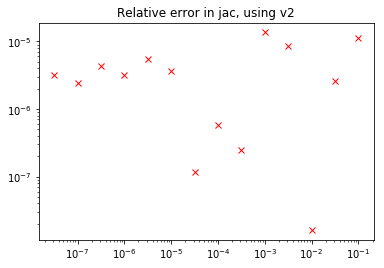

In [665]:
N = 35
y,DM = pseudo.chebdif(N,2); 
D1 = np.real(DM[:,:,0]); D2 = np.real(DM[:,:,1])
ym3 = pseudo.chebdif(N-3,1)[0]
ym5 = pseudo.chebdif(N-5,1)[0]
ym18 = pseudo.chebdif(N-18,1)[0]
normdef = lambda arr: 2.*pseudo.chebnorm(arr,N)**2

def testGradFun(N, epsilon = 1.e-9,**kwargs):
    state, costFun, gradFun = initSystem_test0(N, **kwargs)
    state = _dealiasFun(state,y,ym3)
    #state =  (1. - y**2)#* 1.e-2    
    gradArr = np.zeros(state.shape)
    for i in range(state.size):
        tmpFun1 = np.copy(state); tmpFun2 = np.copy(state)
        tmpFun1[i]  = tmpFun1[i] + epsilon 
        tmpFun2[i]  = tmpFun2[i] - epsilon
        gradArr[i] = ( costFun(tmpFun1) - costFun(tmpFun2) )/2./epsilon
        
    return normdef(gradArr - gradFun(state))/(1.e-14+normdef(gradArr) )

plt.figure()
plt.title("Relative error in jac, using v1")
epsList = []; errList = []
for epsilon in 10**np.arange(-1., -8., -0.5):
    epsList.append(epsilon)
    errList.append(testGradFun(N, epsilon=epsilon, scale=1.e-3, v2=False) )

plt.loglog(epsList, errList, 'rx')
plt.yscale("log")
plt.xscale("log")
plt.show()


plt.figure()
plt.title("Relative error in jac, using v2")
epsList = []; errList = []
for epsilon in 10**np.arange(-1., -8., -0.5):
    epsList.append(epsilon)
    errList.append(testGradFun(N, epsilon=epsilon, scale=1.e-3, v2=True) )

plt.loglog(epsList, errList, 'rx')
plt.yscale("log")
plt.xscale("log")
plt.show()


1. __Previously, we used projecting back and forth to remove aliasing effects. For the cost function, this seemed adequate__
2. __For the jacobian that goes with the cost function, however, it's not as good as I'd want it to be__
3. __The relative error isn't very large, $\sim 10^{-5}$, but that is not good enough for exact solutions. Consider iterations below:__



## Start iterating with scipy.optimize.minimize

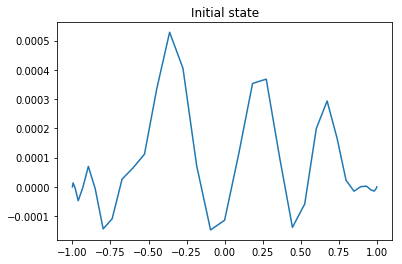

Using v1:
Cost before iterating: 0.0011028389057597563

Running method L-BFGS-B...
Cost for method L-BFGS-B: 1.3554144490149505e-07

Running method Newton-CG...
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 82
         Hessian evaluations: 0
Cost for method Newton-CG: 3.297853138957817e-06

Running method BFGS...
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 41
         Function evaluations: 49
         Gradient evaluations: 49
Cost for method BFGS: 8.887073853560889e-18


Using v2:
Cost before iterating: 0.0011028389057597561

Running method L-BFGS-B...
Cost for method L-BFGS-B: 2.224279897788333e-06

Running method Newton-CG...
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 44
         Hessian

In [667]:
N = 35
np.random.seed(1)
state0, costFun, gradFun = initSystem_test0(N,scale=1.e-3,v2=False)
y = pseudo.chebdif(N,1)[0]
ym15 = pseudo.chebdif(N-15,1)[0]
state0 = _dealiasFun(state0, y, ym15)
plt.plot(y,state0)
plt.title("Initial state")
plt.show()

print("Using v1:")
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )

    
    
_, costFun, gradFun = initSystem_test0(N,scale=1.e-3,v2=True)

print();print()
print("Using v2:")
print("=====================================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )
    

__The error with BFGS is a concern. I don't want to be worrying about these issues so early in the program__

### The way forward

This precision loss has a simple fix. The reason I'm writing everything in terms of $u$ instead of $\tilde{u}$ is to make the formulation look simple (thus avoiding errors down the line). A bit of tinkering showed I can retain this simplicity in the formulation __and__ the accuracy of the method if I hide the derivatives in the function. 

That is, instead of writing code as
$$ u = (1-y^2) \tilde{u} $$
$$ u' = D u $$
$$ u'' = D^2 u $$
I could compute
$$ u = (1-y^2) \tilde{u} $$
$$ u' = -2y\tilde{u} +(1-y^2) \tilde{u}' $$
$$ u'' = -2\tilde{u} - 4y\tilde{u} + (1-y^2)\tilde{u}'' $$
and that makes everything better. 

See below. 

In [668]:
def initSystem_test01(N, scale=1.e-3):
    """
    Define initial state, cost function, and Jacobian
    
    Arguments:
        N: Number of collocation nodes (including wall nodes)
        scale (=1.e-3): Amplitude of initial state
          
    Outputs:
        state: np.ndarray(shape=(N,)), random values, scaled by argument 'scale'
        costFun: Function, produces costFun(state) = scalar
        jacFun: Function, produces jacFun(state) = np.ndarray(shape=(N,))
        
    """
        
    y, DM = pseudo.chebdif(N,2)
    D2 = DM[:,:,1]
    q = (pseudo.clencurt(N)).flatten()
    #weightArr = np.ones(N)/N
    
    randArr =  np.random.randn(N)
    state0 = np.real((1.-y**2) * pseudo.chebcoll_vec( randArr ) )
    # Random coefficients for Chebyshev polynomials, then converted to collocation values
    ym3 = pseudo.chebdif(N-3,1)[0]
    state0 = _dealiasFun(state0, y, ym3)
    
    yColumn = y.reshape((N,1))
    qdot = lambda tmpArr, tmpMat: (q*tmpArr).reshape(1,N) @ tmpMat
    
    def costFun(arr):
        ut = arr.flatten(); uty = D1@ut; utyy = D2@ut
        u = (1.-y**2) * ut
        uy = -2.*y*ut + (1.-y**2)*uty
        uyy = (-2.* ut - 4.*y*uty + (1.-y**2)* utyy)
        
        return q @ (( uyy )**2)

    def gradFun(arr):
        ut = arr.flatten(); uty = D1@ut; utyy = D2@ut
        u = (1.-y**2) * ut
        uy = -2.*y*ut + (1.-y**2)*uty
        uyy = (-2.* ut - 4.*y*uty + (1.-y**2)* utyy)
        
        A2 = -2.* np.identity(N) - 4.* yColumn * D1 + (1.-yColumn**2) * D2
        
        return qdot(2.*uyy, A2).flatten()
        
    
    state0 = scale * state0/np.linalg.norm(state0)
    
    return state0, costFun, gradFun

    
    

The underlying transformation remains the same. The only difference is that now we're defining the derivatives differently, but only in the code. The formulation doesn't see how this is implemented. 

### Test gradFun for new version

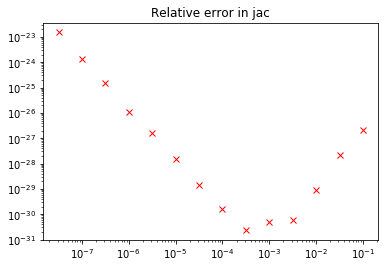

In [670]:
N = 35
y,DM = pseudo.chebdif(N,2); 
D1 = np.real(DM[:,:,0]); D2 = np.real(DM[:,:,1])
ym3 = pseudo.chebdif(N-3,1)[0]
ym5 = pseudo.chebdif(N-5,1)[0]
ym18 = pseudo.chebdif(N-18,1)[0]
normdef = lambda arr: 2.*pseudo.chebnorm(arr,N)**2

def testGradFun(N, epsilon = 1.e-9,**kwargs):
    state, costFun, gradFun = initSystem_test01(N, **kwargs)
    state = _dealiasFun(state,y,ym3)
    #state =  (1. - y**2)#* 1.e-2    
    gradArr = np.zeros(state.shape)
    for i in range(state.size):
        tmpFun1 = np.copy(state); tmpFun2 = np.copy(state)
        tmpFun1[i]  = tmpFun1[i] + epsilon 
        tmpFun2[i]  = tmpFun2[i] - epsilon
        gradArr[i] = ( costFun(tmpFun1) - costFun(tmpFun2) )/2./epsilon
        
    return normdef(gradArr - gradFun(state))/(1.e-14+normdef(gradArr) )

plt.figure()
plt.title("Relative error in jac")
epsList = []; errList = []
for epsilon in 10**np.arange(-1., -8., -0.5):
    epsList.append(epsilon)
    errList.append(testGradFun(N, epsilon=epsilon, scale=1.e-3) )

plt.loglog(epsList, errList, 'rx')
plt.yscale("log")
plt.xscale("log")
plt.show()




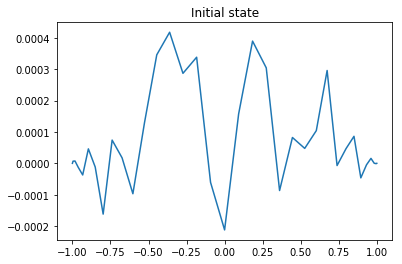

Using new version:
Cost before iterating: 0.005036142604107007

Running method L-BFGS-B...
Cost for method L-BFGS-B: 1.6616177936254844e-07

Running method Newton-CG...
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 48
         Hessian evaluations: 0
Cost for method Newton-CG: 1.3380231515211472e-05

Running method BFGS...
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 40
         Function evaluations: 47
         Gradient evaluations: 47
Cost for method BFGS: 2.809018579232433e-16


In [672]:
N = 35
np.random.seed(1)
state0, costFun, gradFun = initSystem_test01(N,scale=1.e-3)
y = pseudo.chebdif(N,1)[0]
# "Dealiasing" is now included in initSystem_test
plt.plot(y,state0)
plt.title("Initial state")
plt.show()

print("Using new version:")
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )



__And now we're all set, for the simplest system $u'' = 0$__

# Stage 2: Laminar, but with v and p included

Define state-vector with (u,v,p), which are coefficients for (0,0) mode after decomposition, 
$$ u_{total} = (U + u), \hspace{5pt} v_{total} = V + v, \hspace{5pt} p_{total} = P + p.$$
$U$ and $V$ are not solved for. They are approximate solutions that satisfy boundary conditions of Poiseuille or PCoF without any manipulation. $P$ is only due to imposed pressure gradients, and $p$ has no boundary conditions imposed on it. For laminar flow in flat-walled flows (i.e., without grooves), $V=0$.

Setting $\partial_x $ to zero for all but $P_x$, the NSE for $u_{total}, v_{total}, and p_{total}$ are
\begin{align}
    r_x = \partial_t (U + u) &= - v (U' + u') - P_x + \frac{1}{Re} (U'' + u'')\\
    r_y = \partial_t v &= - v v' - p' + \frac{1}{Re} v''\\
    r_d &= v'
\end{align}
Dropping $-P_x + \frac{1}{Re}U''$ from the $x$-momentum (which is the laminar solution), 
\begin{align}
    r_x = \partial_t u &= - v (U' + u') + \frac{1}{Re} u'',\\
    r_y = \partial_t v &= - v v' - p' + \frac{1}{Re}v'',\\
    r_d &= v'.
\end{align}


As before, we will be substiting $u = (1-y^2) \tilde{u}$ and $v = (1-y^2) \tilde{v}$. We define the cost as
$$ F(\tilde{u},\tilde{v},p) = || r_x, r_y , r_d ||^2$$
where the norm for vectors is defined using a weight
$$|| \mathbf{r}_x, \mathbf{r}_y , \mathbf{r}_d ||^2 = \sum\limits_j w_j \big( \mathbf{r}_{x,j}^2 + \mathbf{r}_{y,j}^2 + \mathbf{r}_{d,j}^2 \big)$$
__Remember to express $(\tilde{u},\tilde{v},p)$ in terms of $(u,v, \tilde{p})$ when computing cost__

To ensure divergence-free nature is maintained more often, impose a penalty on the divergence to define the cost as
$$F(\tilde{u},\tilde{v},p;\text{divPenalty}) = \sum\limits_j w_j \big( \mathbf{r}_{x,j}^2 + \mathbf{r}_{y,j}^2 + \text{divPenalty}*\mathbf{r}_{d,j}^2 \big)$$



### Jacobian

The Jacobian is easily extended to this system from the previous. First, let's split the cost function into 3 parts, 
$$ F(\tilde{u},\tilde{v},p) = F_x + F_y + F_d,$$
and calculate the Jacobian for each of the terms, $J_x, J_y, J_d$.

__To avoid confusing with spanwise velocity, we'll use $\mathbf{q}, q_j$ for weights in norm definition__

We will be taking derivatives of $u_j$ ($j^{th}$ element in the vector $\mathbf{u}$) with respect to $\tilde{u}_i$ ($i^{th}$ element in the vector $\tilde{\mathbf{u}}$). To keep expressions simple on the eyes, let's define
\begin{align}
    A^0_{j,i} &= \frac{\partial u_j  }{ \partial \tilde{u}_i } &= (1-y_j^2) I_{j,i} \\
    A^1_{j,i} &= \frac{\partial u'_j }{ \partial \tilde{u}_i } &= -2y_j I_{j,i} + (1-y_j^2) D_{j,i}\\
    A^2_{j,i} &= \frac{\partial u''_j}{ \partial \tilde{u}_i } &= -2I_{j,i} -4y_jD_{j,i} +(1-y_j^2) D^2_{j,i} \\
    B^0_{j,i} &= \frac{\partial v_j  }{ \partial \tilde{v}_i } &= (1-y_j^2) I_{j,i} \\
    B^1_{j,i} &= \frac{\partial v'_j }{ \partial \tilde{v}_i } &= -2y_j I_{j,i} + (1-y_j^2) D_{j,i}\\
    B^2_{j,i} &= \frac{\partial v''_j}{ \partial \tilde{v}_i } &= -2I_{j,i} -4y_jD_{j,i} +(1-y_j^2) D^2_{j,i} \\
\end{align}
where $I$ is the identity matrix and $D$ and $D^2$ are differentiation matrices. 


We will consider two general forms that appear later. 

First:
$$g^1 = \sum_j c_j u^{(n)}_j , $$ 
where $c_j$ is independent of $u$, and $u^{(n)}$ is the $n^{th}$ derivative. In this case, the vector $\partial g^1/\partial \tilde{\mathbf{u}}$ is given by the matrix product
$$ \frac{g^1}{\partial \tilde{\mathbf{u}} } = \text{matmul}( \mathbf{c}^T , A^n ). $$
Note that $g^1$ is a function of $u$ while the derivative is computed w.r.t $\tilde{u}$. Hence the matmul(.,$A^n$). The vectors are all row vectors after the transpose. 

The second form is a product of derivatives of $u$,
$$g^2 = \sum_j c_j u^{(n)}_j u^{(m)}_j) , $$ 
whose vector derivative is obtained using chain rule, 
$$ \frac{g^1}{\partial \mathbf{u} } = 
     \text{matmul}( \mathbf{c}^T * \mathbf{u}^{(n),T} , A^m ) 
    +\text{matmul}( \mathbf{c}^T * \mathbf{u}^{(m),T} , A^n ) .$$
The * represents __elementwise multiplication__ of the row vectors. 


### Partials for $F_x$
\begin{align}
    F_x &= \sum_j \mathbf{q}_j \mathbf{r}_{x,j}^2 \\
        &= \sum_j \mathbf{q}_j \bigg\lbrack  
        \{ v (U' + u') \}^2_j 
        + \frac{1}{Re^2} \{ u'' \}^2_j
        - 2 v \{U' + u' \}_j  \frac{1}{Re} \{u'' \}_j \bigg\rbrack
\end{align}

Following the template for derivatives given above, the $u$-derivative of $F_x$:
\begin{align}
    \frac{\partial F_x}{\partial \tilde{\mathbf{u}} } &= 
           \text{dot}\{2q v(U'+u') v , A^1 \}
        + \frac{1}{Re^2} \text{dot}\{ 2q u'', A^2\}
        - 2 \frac{1}{Re} \big\lbrack \text{dot}\{q v U' ,A^2\}  + \text{dot}\{qvu' ,A^2\} +\text{dot}\{qvu'',A^1\}    \big\rbrack
\end{align}


The $v$-derivative of F_x:
$$
    \frac{\partial F_x}{\partial \tilde{\mathbf{v}} } = 
            \text{dot}\{q  ((U' + u') 2 v )^2,  B^0 \} - 2 \frac{1}{Re} \text{dot}\{ q(U' + u')(u''), B^0 \}
$$
And $p$-derivative: 
$$ \frac{\partial F_x}{\partial p_i } = 0$$





### Partials for $F_y$ :

\begin{align}
    F_y =& \sum_j \mathbf{q}_j \mathbf{r}_{y,j}^2  \\
    &= \sum_j \mathbf{q}_j \bigg\lbrack  
        p'^2_j 
        + \{ vv' \}^2_j 
        + \frac{1}{Re^2} \{v'' \}^2_j
        + 2  \{ p'   vv'\}_j 
        - \frac{2}{Re} \{ vv'v'' \}_j 
        - \frac{2}{Re} \{  p' v'' \}_j 
        \bigg\rbrack
\end{align}

The $u$-derivative,
$$ \frac{\partial F_y}{\partial u_i} = 0  $$

The $v$-derivative,
$$ \frac{\partial F_y}{\partial \tilde{\mathbf{v}}}     = 
        \text{dot}\{2qvv'v, A^1\} + \text{dot}\{2qvv'v', B^0\}
        + \frac{1}{Re^2} \text{dot}\{2qv'', B^2 \}
        + \text{dot}\{ 2qp'   v', B^0\} + \text{dot}\{ 2qp'   v, B^1\} 
        - \frac{2}{Re} \big\lbrack \text{dot}\{q v'v'', B^0 \} + \text{dot}\{q vv'', B^1 \}+\text{dot}\{q vv', B^2 \} \big\rbrack
        - \frac{2}{Re} \text{dot}\{ q p' , B^2 \}  $$

The $p$-derivative,
$$  \frac{\partial F_y}{\partial \mathbf{p} }
    =  \text{dot}\{2qp', D \} 
    +  \text{dot}\{2q   vv', D\}
        - \frac{2}{Re} \text{dot}\{ q  v'', D \}
        $$




### Partials for F_d :
$$ F_d = \text{divPenalty} \sum\limits_j \mathbf{q}_j \mathbf{r}^2_{d,j}
   = \text{divPenalty} \sum\limits_j \mathbf{q}_j \tilde{v}'_j $$
   
And its derivatives
\begin{align}
    \frac{ \partial F_d }{\partial \tilde{\mathbf{u}} } &= 0 \\
    \frac{ \partial F_d }{\partial \tilde{\mathbf{u}} } &= \text{divPenalty} \hspace{8pt} \text{dot}\{ q, B^1 \}  \\
    \frac{ \partial F_d }{\partial \tilde{\mathbf{u}} } &= 0
\end{align}



### Jacobian

Finally, the Jacobian is
$$    J(u,v,p) = \begin{bmatrix} 
                \frac{ \partial F_x }{\partial u_i} + \frac{ \partial F_y }{\partial u_i} + \frac{ \partial F_d }{\partial u_i} \\
                \frac{ \partial F_x }{\partial v_i} + \frac{ \partial F_y }{\partial v_i} + \frac{ \partial F_d }{\partial v_i} \\
                \frac{ \partial F_x }{\partial p_i} + \frac{ \partial F_y }{\partial p_i} + \frac{ \partial F_d }{\partial p_i}
                \end{bmatrix} $$
                
                

# Square root of cost:

One final piece of tweaking. To keep cost on the same order of magnitude as the errors in state, I should take the square root of sum of squares of residuals. Define
$$ G(\chi) = \sqrt{F(\chi)},$$
and take the gradient with respect to $G$, 
$$ \frac{\partial G}{\partial u} = \frac{d G}{d F} \frac{\partial F}{\partial u} =\frac{1}{2\sqrt{F} } \frac{\partial F}{\partial u} = =\frac{1}{2G } \frac{\partial F}{\partial u}$$
and the derivative of $F$ is calculated as before. 


In [2]:
def initSystem_test1(N, scale=1.e-3, flowClass='channel', Re=100., divPenalty=5., 
                     useSqr=True, epsCost = 1.e-33):
    """
    Define initial state, cost function, and Jacobian
    
    Arguments:
        N: Number of collocation nodes (including wall nodes)
        Keywords:
        scale (=1.e-3): Amplitude of initial state
        flowClass: Accepts 'channel' or 'couette'. Sets U accordingly
        Re (=100.): Reynolds number
        divPenalty(=5.): Scales divergence residual to make it converge faster
        useSqr (=True): If True, use sum of squares residual. 
                        If False, use square root of the above residual
        epsCost (=1.e-33): When using square root of sum of squares residual, 
                        add this tiny number before taking the square root. 
                        This helps infinities in the Jacobian. 
                        Note: As this number grows larger, the minimum cost increases.
          
    Outputs:
        state: np.ndarray(shape=(N,)), random values, scaled by argument 'scale'
        costFun: Function, produces costFun(state) = scalar
        jacFun: Function, produces jacFun(state) = np.ndarray(shape=(N,))
        
    """
        
    y, DM = pseudo.chebdif(N,2)
    D2 = DM[:,:,1]
    q = (pseudo.clencurt(N)).flatten()
    if flowClass == 'channel':
        U = 1. - y**2
    else :
        U = -y
        
    U_y = D1 @ U
    U_yy = D2 @ U
    assert (y.ndim==1) and (U.ndim==1)
    randArr =  np.random.randn(3*N)
    state0 = np.concatenate(( 
        pseudo.chebcoll_vec(randArr[:N]),pseudo.chebcoll_vec( randArr[N:2*N] ), pseudo.chebcoll_vec( randArr[2*N:] ) )).real
    # Random coefficients for Chebyshev polynomials, then converted to collocation values
    # "Dealias", to N-3 and back
    ym3 = pseudo.chebdif(N-3,1)[0]
    state0[:N]   = _dealiasFun(state0[:N]  , y, ym3)
    state0[N:-N] = _dealiasFun(state0[N:-N], y, ym3)
    state0[-N:]  = _dealiasFun(state0[-N:] , y, ym3)
    
    yQuad = 1.-y**2
    
    def costFun(arr):
        # r_u = -v (U'+u') + u''/Re,\\
        # r_v = -v v' - p' + v''/Re,\\
        # r_d = v'
        # F(u) = \sum_j q_j (r_u^2 + r_v^2 + div_penalty* r_d^2)
        arr = arr.reshape((3,N))
        arr_y = arr @ D1.T
        arr_yy = arr @ D2.T   # Referencing is easier when u,v,w are row vectors
        
        # Comput u and v derivatives explicitly in terms of ut and vt derivatives
        ut = arr[0]; uty = arr_y[0]; utyy = arr_yy[0]
        vt = arr[1]; vty = arr_y[1]; vtyy = arr_yy[1] 
        py = arr_y[2]
        u = yQuad*ut;   uy = -2.*y*ut + yQuad*uty;   uyy = -2.*ut - 4.*y*uty + yQuad*utyy
        v = yQuad*vt;   vy = -2.*y*vt + yQuad*vty;   vyy = -2.*vt - 4.*y*vty + yQuad*vtyy
        
        r_x = -v * ( U_y + uy ) + uyy/Re
        r_y = -v* vy - py + vyy/Re
        r_d = -vy
        
        costSqr = q @ (r_x**2 + r_y**2 + divPenalty * r_d**2) 
        cost = np.sqrt(epsCost + costSqr) #Need this to ensure finite gradient 
        
        if useSqr:
            return costSqr
        else :
            return cost

    yColumn = y.reshape((N,1))
    I = np.identity(N)
    # Exploit Python's broadcasting to define A0,A1,A2, B0,B1,B2
    A0 = (1.-yColumn**2) * I   # (1-y_j^2) * I_{j,i}
    A1 = -2.*yColumn* I + (1.-yColumn**2) * D1     # -2y_j I_{j,i} + (1-y_j^2) D_{j,i}
    A2 = -2.* I - 4.*yColumn*D1 + (1.-yColumn**2)*D2  # -2 I_{j,i} -4 y_j D_{j,i} + (1-y_j^2) D^2_{j,i}
    B0 = A0
    B1 = A1
    B2 = A2
    
    qdot = lambda tmpArr, tmpMat: (q*tmpArr).reshape((1,N)) @ tmpMat
    
    def gradFun(arr):
        costTmp = costFun(arr)
        arr = arr.reshape((3,N))
        arr_y = arr @ D1.T
        arr_yy = arr @ D2.T   # Referencing is easier when u,v,w are row vectors
        
        # Comput u and v derivatives explicitly in terms of ut and vt derivatives
        ut = arr[0]; uty = arr_y[0]; utyy = arr_yy[0]
        vt = arr[1]; vty = arr_y[1]; vtyy = arr_yy[1] 
        py = arr_y[2]
        u = yQuad*ut;   uy = -2.*y*ut + yQuad*uty;   uyy = -2.*ut - 4.*y*uty + yQuad*utyy
        v = yQuad*vt;   vy = -2.*y*vt + yQuad*vty;   vyy = -2.*vt - 4.*y*vty + yQuad*vtyy
        
        #===============================
        # First, Fx grads
        #dFx/du = qdot\{2 v(U'+u') v , A^1 \}
        #   + (1/Re^2) qdot\{ 2 u'', A^2\}
        #   - 2 (1/Re) \[ qdot\{ v U' ,A^2\}  + qdot\{vu' ,A^2\} +qdot\{vu'',A^1\}    \] 
        gradArr_u =  qdot(2.* v*(U_y+uy)* v , A1 )\
               + (1./Re/Re)* qdot(2.* uyy, A2) \
               - (2./Re) *(    qdot(v* U_y ,A2)  + qdot(v*uy ,A2) +qdot( v*uyy,A1)    )
        
        # dFx/dv = qdot\{  ((U' + u')^2 2 v ),  B^0 \} -  (2/Re) qdot\{ (U' + u')(u''), B^0 \}        
        gradArr_v = qdot( (U_y + uy)**2 * (2.* v ) ,  B0 ) - (2./Re)*qdot(  (U_y+uy)*uyy, B0  )
        
        # dFx/dp = 0
        gradArr_p = np.zeros(gradArr_u.shape)
        
        #==========================
        # Next, Fy grads, expressed in simpler notation:
        # dFy/du = 0  
        gradArr_u += 0.
 
        # dFy/dv = 2 q v v' ( v B1 +  v' B0  )
        #         + (2/Re^2) q v''  B2
        #         + 2 q p' ( v' B0 + v B1 ) 
        #         - (2/Re) ( q v  v'  B2 + q v v'' B1    +  q v'  v'' B0 ) 
        #         - (2/Re) q p' B2
        gradArr_v += qdot(2.*v*vy*v, B1) + qdot(2.*v*vy*vy, B0) \
                    + (1./Re/Re) * qdot(2.*vyy, B2 ) \
                    + qdot(2.*py*v, B1) + qdot(2.*py*vy, B0) \
                    - (2./Re)*(   qdot(vy*vyy, B0) + qdot(v*vyy, B1) + qdot(v*vy, B2)   ) \
                    - (2./Re)*qdot(  py, B2 ) 
        
        # dFy/dp = 2 q p' D + 2 q vt vt'   D - (2/Re) q vt'' D
        gradArr_p += qdot(2.*py, D1) + qdot(2.* v*vy, D1) - (2./Re)*qdot(vyy, D1)
        
        #========================
        # Finally, F_d grads
        # dFd/du = 0
        gradArr_u += 0.
        
        # dFd/dv = divPenalty 2 v' B1   
        gradArr_v += divPenalty * qdot(2.*vy, B1)
        
        # dFd/dp = 0
        gradArr_p += 0.
        
        #=======================
        # Almost done. Now, flatten and concatenate
        assert gradArr_u.size == N
        assert gradArr_v.size == N
        assert gradArr_p.size == N
        
        gradArr =  np.concatenate(( gradArr_u.flatten(), gradArr_v.flatten(), gradArr_p.flatten() ))
        
        
        if useSqr:
            return gradArr
        else :
            return (1./2./costTmp) * gradArr
    
    state0 = 3 * scale * state0/pseudo.chebnorm(state0,N)
    
    return state0, costFun, gradFun
    

    
    

## Test gradFun

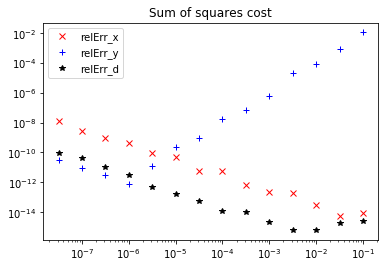

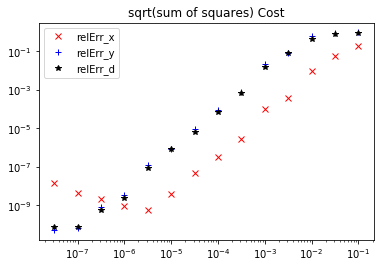

In [5]:
N = 15
y,DM = pseudo.chebdif(N,2); 
D1 = np.real(DM[:,:,0]); D2 = np.real(DM[:,:,1])

normdef = lambda arr: pseudo.chebnorm(arr,N)
def testGradFun(N, epsilon = 1.e-9,**kwargs):
    state, costFun, gradFun = initSystem_test1(N, **kwargs)
    #state =  (1. - y**2)#* 1.e-2    
    gradArr = np.zeros(state.shape)
    for i in range(state.size):
        tmpFun1 = np.copy(state); tmpFun2 = np.copy(state)
        tmpFun1[i]  = tmpFun1[i] + epsilon 
        tmpFun2[i]  = tmpFun2[i] - epsilon
        gradArr[i] = ( costFun(tmpFun1) - costFun(tmpFun2) )/2./epsilon
    
    gradEx =  gradFun(state)
    normx = normdef(gradArr[:N] -gradEx[:N] )/(1.e-11+normdef(gradEx[:N])   )
    normy = normdef(gradArr[N:-N] - gradEx[N:-N] )/(1.e-11+normdef(gradEx[N:-N])   )
    normd = normdef(gradArr[-N:] - gradEx[-N:] )/(1.e-11+normdef(gradEx[-N:])   )
    return normx, normy, normd

plt.figure()
epsList = []; errxList = []; erryList=[]; errdList=[]
for epsilon in 10**np.arange(-1., -8., -0.5):
    epsList.append(epsilon)
    errx, erry, errd = testGradFun(N, epsilon=epsilon, useSqr=True)
    errxList.append(errx )
    erryList.append(erry )
    errdList.append(errd )

plt.title("Sum of squares cost")
plt.loglog(epsList, errxList, 'rx', label='relErr_x')
plt.loglog(epsList, erryList, 'b+', label='relErr_y')
plt.loglog(epsList, errdList, 'k*', label='relErr_d')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


plt.figure()
epsList = []; errxList = []; erryList=[]; errdList=[]
for epsilon in 10**np.arange(-1., -8., -0.5):
    epsList.append(epsilon)
    errx, erry, errd = testGradFun(N, epsilon=epsilon, useSqr=False)
    errxList.append(errx )
    erryList.append(erry )
    errdList.append(errd )

plt.title("sqrt(sum of squares) Cost")
plt.loglog(epsList, errxList, 'rx', label='relErr_x')
plt.loglog(epsList, erryList, 'b+', label='relErr_y')
plt.loglog(epsList, errdList, 'k*', label='relErr_d')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()



__The relative errors look quite reasonable. In fact, better than you'd expect for x and d errors__

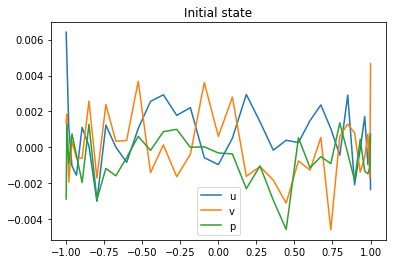

Using Sum of Squares cost:
Cost before iterating: 0.02028320990681657

Running method L-BFGS-B...
Cost for method L-BFGS-B: 5.609780080122514e-07
Run time is 83 ms

Running method Newton-CG...
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 4642
         Hessian evaluations: 0
Cost for method Newton-CG: 1.815939832893276e-18
Run time is 1428 ms

Running method BFGS...
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 95
         Function evaluations: 104
         Gradient evaluations: 104
Cost for method BFGS: 6.5869165560252915e-09
Run time is 89 ms



Using sqrt(Sum of Squares) cost with epsCost 1e-10:
Cost before iterating: 0.1424191349742603

Running method L-BFGS-B...
Cost for method L-BFGS-B: 3.0304471224318355e-05
Run time is 773 ms

Running method Newton-CG...
         Current function value: 0.142419
       

In [28]:
import time
N = 35
np.random.seed(1)
state0 = initSystem_test1(N,scale=1.e-3, useSqr=False)[0]
y = pseudo.chebdif(N,1)[0]
# "Dealiasing" is now included in initSystem_test
plt.plot(y,state0[:N],label='u')
plt.plot(y,state0[N:-N],label='v')
plt.plot(y,state0[-N:],label='p')
plt.legend()
plt.title("Initial state")
plt.show()

print("Using Sum of Squares cost:")
_, costFun, gradFun = initSystem_test1(N,scale=1.e-3, useSqr=True)
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    t0 = time.time()
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )
    t1 = time.time()
    print("Run time is %d ms"%(1000*(t1-t0)) )

    
print(); print(); print()    
epsCost = 1.e-10
print("Using sqrt(Sum of Squares) cost with epsCost %.3g:"%epsCost)
_, costFun, gradFun = initSystem_test1(N,scale=1.e-3, useSqr=False, epsCost=epsCost)
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    t0 = time.time()
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )
    t1 = time.time()
    print("Run time is %d ms"%(1000*(t1-t0)) )
    
print(); print(); print()    
epsCost = 1.e-16
print("Using sqrt(Sum of Squares) cost with epsCost %.3g:"%epsCost)
_, costFun, gradFun = initSystem_test1(N,scale=1.e-3, useSqr=False, epsCost=epsCost)
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    t0 = time.time()
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )
    t1 = time.time()
    print("Run time is %d ms"%(1000*(t1-t0)) )

print(); print(); print()    
epsCost = 1.e-24
print("Using sqrt(Sum of Squares) cost with epsCost %.3g:"%epsCost)
_, costFun, gradFun = initSystem_test1(N,scale=1.e-3, useSqr=False, epsCost=epsCost)
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    t0 = time.time()
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )
    t1 = time.time()
    print("Run time is %d ms"%(1000*(t1-t0)) )
    
print(); print(); print()    
epsCost = 1.e-30
print("Using sqrt(Sum of Squares) cost with epsCost %.3g:"%epsCost)
_, costFun, gradFun = initSystem_test1(N,scale=1.e-3, useSqr=False, epsCost=epsCost)
print("===========================")
print("Cost before iterating:", costFun(state0) )
methods = ['L-BFGS-B', 'Newton-CG', 'BFGS']
for method in methods:
    print()
    print("Running method %s..."%method)
    t0 = time.time()
    t0 = time.time()
    res = minimize(costFun, state0, method=method, jac=gradFun,
                        options={'disp': True, 'maxiter':100000})
    print("Cost for method %s:"%method,costFun(res.x) )
    t1 = time.time()
    print("Run time is %d ms"%(1000*(t1-t0)) )
    


In [684]:
costFun( np.concatenate(( np.zeros(N), np.zeros(N), np.ones(N) )) ), costFun( res.x )

(9.996655934713691e-30, 6.5869165560252915e-09)

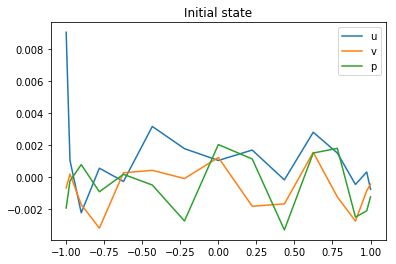

Using Sum of Squares cost:


In [6]:
import time
N = 15
np.random.seed(1)
state0 = initSystem_test1(N,scale=1.e-3, useSqr=False)[0]
y = pseudo.chebdif(N,1)[0]
# "Dealiasing" is now included in initSystem_test
plt.plot(y,state0[:N],label='u')
plt.plot(y,state0[N:-N],label='v')
plt.plot(y,state0[-N:],label='p')
plt.legend()
plt.title("Initial state")
plt.show()

print("Using Sum of Squares cost:")
_, costFun, gradFun = initSystem_test1(N,scale=1.e-3, useSqr=True)





In [17]:
def getMutation(stdArr, c=None):
    mutation = np.zeros((3, N))
    if (c is None):
        for lc in range(3):
            mutation[lc] = ( np.random.normal(0., stdArr[lc], (y.size,) ) )
    else :
        mutation[c] = ( np.random.normal(0., stdArr[c], (y.size,) ) )
    
    return mutation

In [65]:
residFun = costFun
#state = 1.e-10*np.ones((kxArr.size, kzArr.size, 4, N), dtype=np.complex)
parent = state0
stdArr = 1.e-2*np.random.rand(3) # All modes except u_00 should be zero
#stdArr[0] = 1.e-4
costFun(parent)

0.0018105117660703759

0 0.0018099047924284592 0.0005993486666604538 0.009162701849956456
1 0.0018097711246686135 0.0006592835333264993 0.008946957693874678
2 0.0018095182269236725 0.0007252118866591492 0.008736293430344861
3 0.0018095182269236725 0.0007081361126101992 0.008530589448672524
4 0.001809108870420714 0.0007789497238712192 0.00832972895450587
5 0.001808936933122225 0.0008568446962583412 0.008133597903522435
6 0.0018088774762706303 0.0009425291658841754 0.007942084936677148
7 0.0018088774762706303 0.0009203364586668048 0.007755081316975022
8 0.0016182356858448748 0.0008986662989434143 0.007572480867732608
9 0.0016182356858448748 0.0008775063828575707 0.007394179912293122
10 0.0016182356858448748 0.0008568446962583413 0.007220077215161042
20 0.0011552673973439496 0.0010873862217215314 0.00568931695547153
30 0.0011396023817943084 0.0017512463839447442 0.004483099897027053
40 0.0010944201545463829 0.0015545560851215419 0.0035326182112942668
50 0.0008837085941978071 0.0012249678264855178 0.003135854090

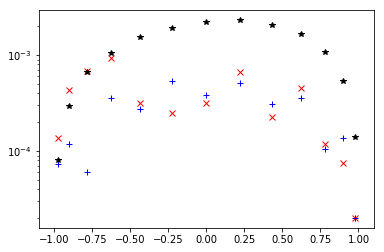

In [66]:
gradFunFac = 1.*np.average(stdArr)
iter0 = 0 #======================= Important
iterMax = 1501
iterSwitch0  = 50
iterSwitchInt= 20
alpha = 1.1
iterPrint = 10
tol = 1.e-14
costPar = costFun(parent)

np.set_printoptions(precision=4)
for iternum in range(iter0,iterMax):
    if (iternum<50) or (iternum%20):
        for c in range(3):
            #offspring = parent - gradFunFac*gradFun(parent) + getMutation(stdArr, c=c).reshape(parent.shape)
            mutation = getMutation(stdArr, c=c).reshape(parent.shape)
            offspring_m1 = parent -0.5*mutation 
            offspring_p1 = parent +0.5*mutation
            offspring_p2 = parent + 1.*mutation
            offspring_p3 = parent + 2.*mutation
            costOff_m1 = residFun(offspring_m1)
            costOff_p1 = residFun(offspring_p1)
            costOff_p2 = residFun(offspring_p2)
            costOff_p3 = residFun(offspring_p3)
            costOffList = np.array([costOff_m1, costOff_p1, costOff_p2, costOff_p3])
            offspringList = np.array([offspring_m1, offspring_p1, offspring_p2, offspring_p3])
            costOff_ind = np.argmin(costOffList)
            costOff = costOffList[costOff_ind]
            offspring = offspringList[costOff_ind]
            

            if costOff <= costPar:
                parent = np.copy(offspring)
                costPar = costOff
                stdArr[c] = stdArr[c]*alpha
            else :
                parent = parent
                costPar = costPar
                stdArr[c] = stdArr[c] * alpha**(-1./4.)
    else :
        mutation = getMutation(stdArr).reshape(parent.shape)
        offspring_m1 = parent -0.5*mutation 
        offspring_p1 = parent +0.5*mutation
        offspring_p2 = parent + 1.*mutation
        offspring_p3 = parent + 2.*mutation
        costOff_m1 = residFun(offspring_m1)
        costOff_p1 = residFun(offspring_p1)
        costOff_p2 = residFun(offspring_p2)
        costOff_p3 = residFun(offspring_p3)
        costOffList = np.array([costOff_m1, costOff_p1, costOff_p2, costOff_p3])
        offspringList = np.array([offspring_m1, offspring_p1, offspring_p2, offspring_p3])
        costOff_ind = np.argmin(costOffList)
        costOff = costOffList[costOff_ind]
        offspring = offspringList[costOff_ind]
            
        if costOff <= costPar:
            parent = np.copy(offspring)
            stdArr = stdArr*alpha
            costPar = costOff
        else :
            parent = parent
            costPar = costPar
            stdArr = stdArr * alpha**(-1./4.)
        
    if min(costOff,costPar) < tol:
        print(); print("Exiting...")
        print(iternum, min(costOff,costPar))
        break

    if iternum <= 10:
        print(iternum, min(costOff, costPar), np.amin(stdArr.flat),np.amax(stdArr.flat) )
    
    if (10 < iternum <= 100):
        if iternum%10 == 0:
            print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
    
    if (100 < iternum <= 1000):
        if iternum%100 == 0:
            print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
    
    if (1000 < iternum <= 10000):
        if iternum%1000 == 0:
            print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
            
plt.semilogy(y, np.abs( (1.-y**2)*parent[:N] ), 'rx')
plt.semilogy(y, np.abs( (1.-y**2)*parent[N:2*N] ), 'b+')
plt.semilogy(y, np.abs( (1.-y**2)*parent[2*N:] ), 'k*')
plt.show()


In [33]:
stdArr

array([7.9307e-08, 2.1643e-10, 1.8386e-11])

In [29]:
parent.shape

(45,)